# Perceived Dependence of Stocks and Correlation: Monthly Regression

For my thesis, i will look into the difference between the perceived dependence and the actual correlation of the return of stocks with the market return. In this notebook, we will try to import the data we have processed (in this notebook, on a monthly basis) and do some statistical tests on them.

**Difference with main results: Instead of sorting the stocks into Comove ranks (controlling for beta), we will now sort the stocks into Beta ranks (controlling for Comove). Section 1 stays the same.**

**Difference with main results: adjusted for DAX. Deleted Patton and Timmerman test.**

In [9]:
# Note that all of the returns and factors are in decimal and monthly forms. In the final results, one could convert to yearly percentages
# by multiplying with 12 * 100.

In [10]:
# TODO Run Patton with bootstraps = 10 000 on another computer, runs out of memory now. Research how many bootstraps are needed.

In [11]:
# TODO Graph: Cummulative Alpha of High-Low Comovement and High-Low Beta.
# Ik denk dat ik dan die 4F Alpha's moet schatten per maand, voor alle vijf comove ranks met return - risk free,
# en dan de high-minus low alpha eruit halen door de alpha  --> nee zwz niet juist
# hebben ze die carhartt per jaar geschat?
# mss hebben ze gewoon die return gepakt en dan die andere factoren * geschatte coeff ervan getrokken? --> dit navragen aan promotor

# 1. Imports

Let's import some needed libs first.

In [12]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.regression.linear_model import OLS
from statsmodels.stats.sandwich_covariance import cov_hac
from scipy.stats import spearmanr
from sklearn.utils import resample
from matplotlib.ticker import PercentFormatter

Now, we can read the Excel file that we created when running the notebook Data_Monthly. This notebook has prepared our data for the analysis.

In [13]:
Data_ExcelFile ='Monthly Data.xlsx'
data =  pd.read_excel(Data_ExcelFile)

# Remove the first numbered Index column. We'll use .iloc here for slicing.
data = data.iloc[:, 1:]
# Set the MMYYYY column as index
data.set_index('MMYYYY', inplace=True)

In [14]:
data

,Avg. Comove,Beta rank,HighestBeta_Dummy,Avg. Beta,Avg. Return,Monthly Market Return,Year,Month,Mkt-RF,RF,...,HML,HML_Devil,RMW,CMA,UMD,UMD_Trend,BAB,QMJ,Carry,Seasonal
MMYYYY,,,,,,,,,,,,,,,,,,,,,
72000,48.427673,1,0,0.304065,0.063250,0.042353,2000,7,-0.0158,0.0048,...,0.0330,0.009291,-0.0015,-0.0011,-0.000488,0.002383,-0.015991,0.008098,-0.017318,-0.010766
72000,48.584906,2,0,0.418850,0.109366,0.042353,2000,7,-0.0158,0.0048,...,0.0330,0.009291,-0.0015,-0.0011,-0.000488,0.002383,-0.015991,0.008098,-0.017318,-0.010766
72000,49.433962,3,0,0.656257,0.101145,0.042353,2000,7,-0.0158,0.0048,...,0.0330,0.009291,-0.0015,-0.0011,-0.000488,0.002383,-0.015991,0.008098,-0.017318,-0.010766
72000,50.000000,4,0,0.553398,0.121049,0.042353,2000,7,-0.0158,0.0048,...,0.0330,0.009291,-0.0015,-0.0011,-0.000488,0.002383,-0.015991,0.008098,-0.017318,-0.010766
72000,49.292453,5,1,0.877741,0.027406,0.042353,2000,7,-0.0158,0.0048,...,0.0330,0.009291,-0.0015,-0.0011,-0.000488,0.002383,-0.015991,0.008098,-0.017318,-0.010766
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122022,52.452830,1,0,0.527154,-0.010869,-0.032885,2022,12,-0.0109,0.0033,...,0.0258,0.013184,-0.0085,0.0104,0.014152,NaN,0.035709,0.002379,NaN,NaN
122022,50.943396,2,0,0.742224,-0.016457,-0.032885,2022,12,-0.0109,0.0033,...,0.0258,0.013184,-0.0085,0.0104,0.014152,NaN,0.035709,0.002379,NaN,NaN
122022,50.566038,3,0,0.909490,-0.021882,-0.032885,2022,12,-0.0109,0.0033,...,0.0258,0.013184,-0.0085,0.0104,0.014152,NaN,0.035709,0.002379,NaN,NaN


# 2. Regression Analysis

### 2.1 Autocorrelation

An Autoregressive (AR) process is a type of stochastic time series model in which the current value of the series is based on the past values. The simplest form of an AR model is the AR(1) model, where the current value of the series $Y_t$ is based on the immediately preceding value $Y_t-1$ plus a stochastic error term $e_t$: $Y_t = \phi  Y_t-1 + e_t$ . Here, $\phi$ (phi) is a parameter that measures the influence of the past value on the current value. For an AR(p) model, the current value depends on the previous p values: $Y_t = \phi_1  Y_t-1 + \phi_2  Y_t-2 + ... + \phi_p  Y_t-p  +e_t$ . We will determine the value of p in our return variable using different methods. Because of the correlation, we cannot use normal OLS estimators. We will use Newey-West estimators in our regression with the correct number of lags (p) to correct for the time-dependency of returns in our dataset.


 First, let's look at the Autocorrelation Function (ACF) and the Partial Autocorrelation Function (PACF) per Beta Rank.

In [15]:
data

,Avg. Comove,Beta rank,HighestBeta_Dummy,Avg. Beta,Avg. Return,Monthly Market Return,Year,Month,Mkt-RF,RF,...,HML,HML_Devil,RMW,CMA,UMD,UMD_Trend,BAB,QMJ,Carry,Seasonal
MMYYYY,,,,,,,,,,,,,,,,,,,,,
72000,48.427673,1,0,0.304065,0.063250,0.042353,2000,7,-0.0158,0.0048,...,0.0330,0.009291,-0.0015,-0.0011,-0.000488,0.002383,-0.015991,0.008098,-0.017318,-0.010766
72000,48.584906,2,0,0.418850,0.109366,0.042353,2000,7,-0.0158,0.0048,...,0.0330,0.009291,-0.0015,-0.0011,-0.000488,0.002383,-0.015991,0.008098,-0.017318,-0.010766
72000,49.433962,3,0,0.656257,0.101145,0.042353,2000,7,-0.0158,0.0048,...,0.0330,0.009291,-0.0015,-0.0011,-0.000488,0.002383,-0.015991,0.008098,-0.017318,-0.010766
72000,50.000000,4,0,0.553398,0.121049,0.042353,2000,7,-0.0158,0.0048,...,0.0330,0.009291,-0.0015,-0.0011,-0.000488,0.002383,-0.015991,0.008098,-0.017318,-0.010766
72000,49.292453,5,1,0.877741,0.027406,0.042353,2000,7,-0.0158,0.0048,...,0.0330,0.009291,-0.0015,-0.0011,-0.000488,0.002383,-0.015991,0.008098,-0.017318,-0.010766
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122022,52.452830,1,0,0.527154,-0.010869,-0.032885,2022,12,-0.0109,0.0033,...,0.0258,0.013184,-0.0085,0.0104,0.014152,NaN,0.035709,0.002379,NaN,NaN
122022,50.943396,2,0,0.742224,-0.016457,-0.032885,2022,12,-0.0109,0.0033,...,0.0258,0.013184,-0.0085,0.0104,0.014152,NaN,0.035709,0.002379,NaN,NaN
122022,50.566038,3,0,0.909490,-0.021882,-0.032885,2022,12,-0.0109,0.0033,...,0.0258,0.013184,-0.0085,0.0104,0.014152,NaN,0.035709,0.002379,NaN,NaN


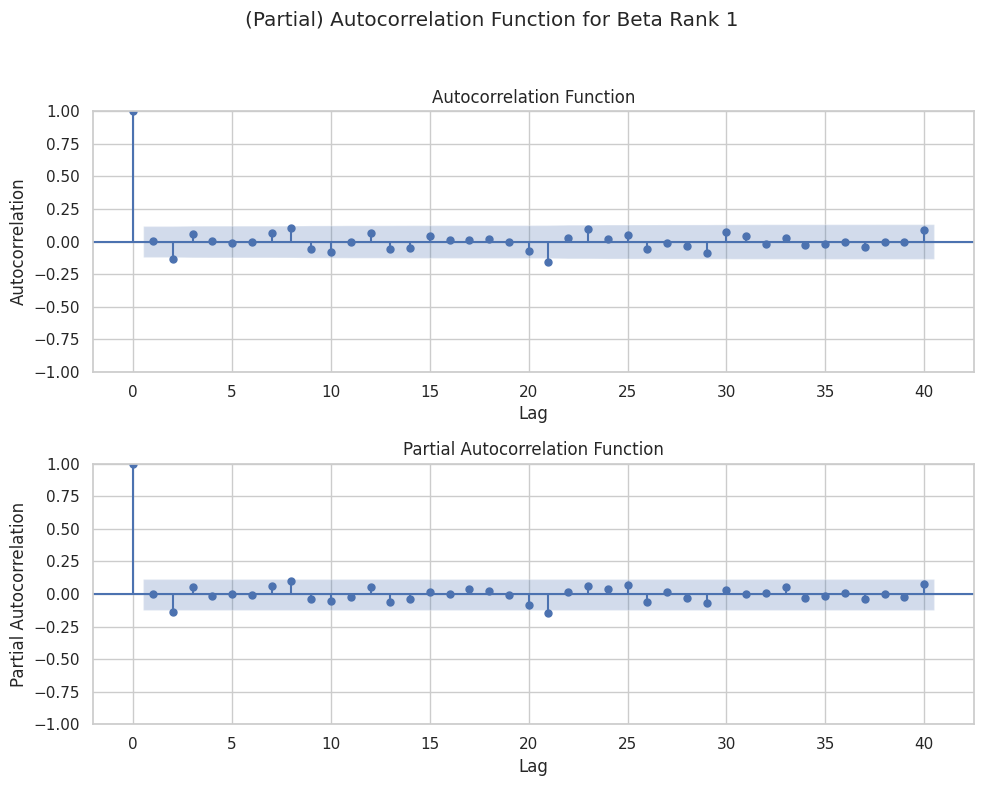

In [16]:
for rank in range(1,6):
    df = data[data['Beta rank'] == rank]
    Y = df['Avg. Return']

    # Apply Seaborn styles for better aesthetics
    sns.set_theme(style="whitegrid")

    # Plot ACF and PACF
    fig, ax = plt.subplots(2, 1, figsize=(10, 8))
    sm.graphics.tsa.plot_acf(Y, lags=40, ax=ax[0])  # Change lags as needed
    sm.graphics.tsa.plot_pacf(Y, lags=40, ax=ax[1])  # Change lags as needed

    # Set axis labels
    ax[0].set_title('Autocorrelation Function')
    ax[0].set_xlabel('Lag')
    ax[0].set_ylabel('Autocorrelation')

    ax[1].set_title('Partial Autocorrelation Function')
    ax[1].set_xlabel('Lag')
    ax[1].set_ylabel('Partial Autocorrelation')

    #Add a title for the whole figure
    fig.suptitle(f"(Partial) Autocorrelation Function for Beta Rank {rank}")
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust the subplots to fit the suptitle

    if rank == 1:
        plt.show() # Will be similar to others

    plt.savefig(f"Autocorrelation_Rank{rank}.png") #Note that all ranks should have the same figure more or less
    plt.close()


Note that is is logical that the Comove ranks have the same ACF and PACF, since they should have the same time-dependency. Interpreting the plots:
- ACF: This shows the correlation of the time series with its own lags. The y-axis measures the correlation coefficient, which ranges from -1 to 1. Each dot (or bar) represents the correlation at a different lag, where lag 0 is the correlation of the series with itself (hence, it is 1). The blue shaded area represents the confidence interval, typically set at 95%. For your ACF plot, the correlation drops sharply after lag 1 and remains within the confidence bounds for subsequent lags. This suggests that there is a significant correlation at lag 0 and potentially some seasonality or other cyclical patterns given the waves in autocorrelation that do not seem significant (they are within the confidence band).
- PACF: This plot shows the partial correlation of each lag after accounting for previous lags. Similar to the ACF, the y-axis represents the partial correlation coefficient. The PACF spike at lag 1 is significant, falling (barely) outside the confidence bounds, indicating that a lag of 1 is predictive of the current value after adjusting for the influence of all other lags. Following lags do not show any large significant partial correlation.

Even when the lag=1 is barely significant, we could still use this. It is standard in the finance literature. Based on these plots, an AR(1) model may be sufficient to model this time series data. Note as well that, Andrews, D.W.K. (1991), present a method for determining the correct number of lags in his paper "Heteroskedasticity and Autocorrelation Consistent Covariance Matrix Estimation". This method suggests using the model selection criteria to determine the lag length. There can be different criteria, but one of them is the Bayesian Information Criterion (BIC). Information criteria like BIC balance model fit against model complexity (in this case, the number of lags) to select the most appropriate model.

In [17]:
# Determine the optimal lag length
df = data[data['Beta rank'] == 1] # Will be same for all ranks
X = df[['Mkt-RF', 'SMB', 'HML', 'UMD']]
y = df['Avg. Return']
best_lag = 0
best_criteria = np.inf
for lag in range(1, 21):  # Test up to 20 lags, for example
    model = OLS(y, X).fit(cov_type='HAC', cov_kwds={'maxlags': lag})
    criteria = model.bic  # Can use AIC or BIC
    if criteria < best_criteria:
        best_criteria = criteria
        best_lag = lag

print(f"Optimal number of lags based on BIC: {best_lag}")

Optimal number of lags based on BIC: 1


Note that this method also suggests using only 1 lag.

### 2.2 Functions needed for this

In this section, we make some functions to facilitate an efficient testing process.

This function is used to replace Nan and Inf values in the data:

In [18]:
# Takes a copy of the given df and deletes rows of the data with nan or inf values in the copy. Returns the copy.
def replace_nan(data):
    rows_with_inf_or_nan = data.replace([np.inf, -np.inf], np.nan).isna().any(axis=1)
        # Print rows with 'inf' or 'NaN'
    print("Rows with 'inf' or 'NaN':")
    print(data[rows_with_inf_or_nan])

        # Replace 'inf' and '-inf' with 'NaN'
    clean_data = data.replace([np.inf, -np.inf], np.nan, inplace=False)

        # Remove rows with 'NaN'
    clean_data.dropna(inplace=True)

    return clean_data

This function is used to test a model for regression with Newey-West estimators, given the dataframe (without Inf and Nan values), the Y-variable and the X-variable.

In [19]:
# Given the data and the variables, return the model and the summary.
def fit_model_with_newey_west_se(data, X_vars, y_var):
    """
    Fits an OLS regression model with Newey-West standard errors.

    Parameters:
    - data: pandas.DataFrame containing the dataset.
    - X_vars: list of strings, names of the columns to use as independent variables.
    - y_var: string, name of the column to use as the dependent variable.

    Returns:
    - A tuple of (model, summary) where:
      - model is the fitted OLS model object.
      - summary is the summary of the fitted model, including statistics.

    Example Usage:
    Assuming 'data' is your DataFrame with appropriate columns
    model, summary = fit_model_with_newey_west_se(data, ['HighestComove_Dummy'], 'Avg. Yearly Return')
    print(summary)
    """
    # Define independent variables for the model
    X = data[X_vars]  # Selecting specified independent variables
    X = sm.add_constant(X)  # Adds a constant term to the predictor

    # Define the dependent variable
    y = data[y_var]

    # Fit the model with Newey-West standard errors
    model = sm.OLS(y, X).fit(cov_type='HAC', cov_kwds={'maxlags': 1}) #See previous section

    # Getting summary of the model
    summary = model.summary()

    return model, summary

The following functions are used to output the results of the regression.
- `add_significance stars()`: given a panda series with a column "P>|z|", returns the according number of stars as a string.
- `extract_coefficients_and_significance()`: given a model, returns a dictionary where the coefficient and its stars are stored as a string for each variable. It uses the function `add_significance_stars()` to do so. It is used in other functions, such as `run_modelsPerRank_and_compile_results()`, to summarize multiple models at the same time.
- `extract_results_to_dataframe()`: given a model, returns a dataframe with as columns the coefficients, p-value and the significance stars. The rows represent each variable. It uses the function `add_significance_stars()` to do so. It is used to showcase the results of one single model.

In [20]:
# For displaying significance levels, we will manually add asterisks based on p-values. Will only do so for one p-value and coefficient. Will return starts without coeff as a string.
def add_significance_stars(row):
    """
    Adds asterisks to denote significance levels based on the p-value.

    Parameters:
    - row: A pandas Series object representing a row from the DataFrame.

    Returns:
    - A string with asterisks representing the significance level.
    """
    if row['P>|z|'] < 0.01:
        return '***'
    elif row['P>|z|'] < 0.05:
        return '**'
    elif row['P>|z|'] < 0.1:
        return '*'
    return ''

In [21]:
# For displaying significance levels, we will manually add asterisks based on p-values. Will do so for more then 1 variable. Will return a dictionairy with as index the const + all variable names. The value will be the coeff + significance stars as a string.
def extract_coefficients_and_significance(model):
    """
    Extracts the model coefficients and significance levels, formats them into a string,
    and returns a dictionary with variable names as keys.

    Parameters:
    - model: The fitted model object from statsmodels.

    Returns:
    - A dictionary with variable names as keys and formatted strings (coefficient + significance)
      as values. The constant term is labeled as 'alpha'.
    """
    results = {}
    for index, row in model.summary2().tables[1].iterrows():
        coeff = row['Coef.']
        p_val = row['P>|z|']
        significance = add_significance_stars({'P>|z|': p_val})

        # Rename 'const' to 'alpha'
        if index == 'const':
            index = 'Alpha'

        results[index] = f"{coeff}{significance}"
    return results

In [22]:
# For displaying significance levels, we will manually add asterisks based on p-values. Will do so for more then 1 variable. Will return a dataframe with seperate columns for coef, pval and stars. The rows are const + variables tested in the model.
def extract_results_to_dataframe(model):
    """
    Extracts the model coefficients and p-values into a pandas DataFrame
    and marks the significance levels.

    Parameters:
    - model: The fitted model object from statsmodels.

    Returns:
    - A pandas DataFrame containing coefficients, p-values, and significance levels.
    """
    # Extracting results to DataFrame
    results_df = pd.DataFrame({
        'Coefficient': model.params,
        'P>|z|': model.pvalues
    }).reset_index()

    # Adding asterisks for significance levels
    results_df['Significance'] = results_df.apply(add_significance_stars, axis=1)

    return results_df

This function runs a Carhartt 4-Factor model on every row in the data. It returns a dataframe with Beta rank as rows, and alpha + the variables as columns. The values are a string of their coefficients and their asterixes. It uses the functions `extract_coefficients_and_significance` and `fit_model_with_newey_west_se()`.

In [23]:
# Runs a carhartt factor model on every row in data. Returns a dataframe with Beta rank as rows, alpha + X variables as columns, and as values coefficients and their asterixes.
def run_modelsPerRank_and_compile_results(data):

    all_vars = ['Alpha', 'Mkt-RF', 'SMB', 'HML', 'UMD']    # Include 'alpha' in the list of variables for the final DataFrame
    results_dict = {var: [] for var in ['Beta rank'] + all_vars}  # Initialize dict

    # Loop through each model specification
    for rank in range(1,6):
        df = data[data['Beta rank'] == rank]
        df = df[['Avg. Return Excess', 'Mkt-RF', 'SMB', 'HML', 'UMD']]
        model, _ = fit_model_with_newey_west_se(df,X, Y)
        coeffs_significance = extract_coefficients_and_significance(model)

        # Preparing row for final DataFrame
        row = {'Beta rank': rank}
        # Ensure every variable (including alpha) has an entry for each model
        for var in all_vars:
            row[var] = coeffs_significance.get(var, '')  # Use empty string if not present

        for key, value in row.items():
            results_dict[key].append(value)

    return pd.DataFrame(results_dict)

### 2.3 Results per Beta rank

#### 2.3.1 Raw Returns

Firstly, we will create a new column *Avg. Return Excess* in our *data*  dataframe, that is equal to the average return of the stocks in that portfolio minus the risk-free rate of that month. Then, we will take the average of this new column for all portfolio's with the same Beta rank. These averages will be stored in the column *Raw Return* of the newly created dataframe *results_perBeta*.

In [24]:
# Step 1: Create a new column 'Avg. Return Excess' in the data df
data['Avg. Return Excess'] = data['Avg. Return'] - data['RF']

# Step 2: Group by 'Beta rank' and calculate the average 'Avg. Return Excess' for each rank
resultsPerBeta_RawAndCarhartt = data.groupby('Beta rank')['Avg. Return Excess'].mean().reset_index()

# Renaming the column to 'Raw Return'
resultsPerBeta_RawAndCarhartt.rename(columns={'Avg. Return Excess': 'Raw Return'}, inplace=True) # Raw Return is the Mean( Avg. Return - Risk Free rate) per comove rank.

# Setting 'Beta rank' as the index
resultsPerBeta_RawAndCarhartt.set_index('Beta rank', inplace=True)

In [25]:
resultsPerBeta_RawAndCarhartt

,Raw Return
Beta rank,
1,0.006427
2,0.005922
3,0.003323
4,0.001077
5,0.003750


#### 2.3.2 Carhart 4F

In the following, we will take the portfolios of the same Comove rank together, and perform the Carhartt Alpha analysis on them across months. The results of the constant will be stored in the column *Carhartt Alpha* of the *results_perComove* dataframe. The coefficients and asterixes of all variables can be found in the *resultsPerComove_df*.

In [26]:
Y = [ 'Avg. Return Excess']
X = ['Mkt-RF', 'SMB', 'HML', 'UMD']

In [27]:
# Coefficients and significance of all variables in 4F per beta rank.
resultsPerBeta_allVariables = run_modelsPerRank_and_compile_results(data)
resultsPerBeta_allVariables.set_index('Beta rank')

,Alpha,Mkt-RF,SMB,HML,UMD
Beta rank,,,,,
1,0.007485246888905186***,0.5512135864147882***,-0.3634185509358244**,-0.26999439453280455**,-0.15739831874489324**
2,0.007306078879432626***,0.7048203099683993***,-0.3886347444449191**,-0.026876205919710124,-0.33177393482732404***
3,0.0029893232627650904,0.8378734545701179***,-0.3077581562985374*,-0.07209395680611905,-0.21845212534925232**
4,0.0032944581975437393,0.9109395548725178***,-0.37967705086626446**,0.004182235580236483,-0.5091460233629514***
5,0.006973303662419509**,1.0340506109737189***,-0.5166527792843076**,-0.043571612145112994,-0.6124517430176525***


In [28]:
#Storing carhartt alpha of each beta rank into resultsPerBeta_RawAndCarhartt dataframe
resultsPerBeta_RawAndCarhartt['Carhartt Alpha'] = resultsPerBeta_allVariables['Alpha'].values
resultsPerBeta_RawAndCarhartt['Carhartt Alpha'] = resultsPerBeta_RawAndCarhartt['Carhartt Alpha'].astype(str)
resultsPerBeta_RawAndCarhartt['Carhartt Alpha'] = resultsPerBeta_RawAndCarhartt['Carhartt Alpha'].str.replace("***", "", regex=False) #There are no stars in this table. Note that except for Comove rank 1 all are 1% significant
resultsPerBeta_RawAndCarhartt

,Raw Return,Carhartt Alpha
Beta rank,,
1,0.006427,0.007485246888905186
2,0.005922,0.007306078879432626
3,0.003323,0.0029893232627650904
4,0.001077,0.0032944581975437393
5,0.003750,0.006973303662419509**


### 2.4 Results for the High-Low Portfolio

In what follows, we will work with a high-low portfolio. In this portfolio, the portfolio return is the difference between the High Beta portfolio (rank 5) of that MMYYYY and the low Beta portfolio (rank 1) of that MMYYYY. Because we already take the difference of two portfolio's, we will work with the difference in average return instead of substracting the average return with the risk-free rate.

In [29]:
# Filter rows where Beta rank is 1 or 5
dataHighLow = data[data['Beta rank'].isin([1, 5])]

#### 2.4.1 Raw Returns (With Dummy Variable)

Let's first just do a raw model: *Difference in average return = const + coefficient * HighestComove_Dummy*. In this model, the constant would be return of the low beta portfolio. The coefficient would be the return premium we would make applying our high-minus-low beta strategy.

In [30]:
X = ['HighestBeta_Dummy']
Y = 'Avg. Return'
df = dataHighLow[['Avg. Return', 'HighestBeta_Dummy']] # We hebben enkel deze data nodig, en die is aanwezig voor alle tijdspunten. We hoeven nog geen Nan eruit te halen want er zijn er geen.

In [31]:
model, summary = fit_model_with_newey_west_se(df, X, Y)
print(summary)

                            OLS Regression Results                            
Dep. Variable:            Avg. Return   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.2868
Date:                Sat, 18 May 2024   Prob (F-statistic):              0.592
Time:                        15:13:31   Log-Likelihood:                 664.24
No. Observations:                 540   AIC:                            -1324.
Df Residuals:                     538   BIC:                            -1316.
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0076      0.00

In [32]:
resultsHighLow_Raw = extract_results_to_dataframe(model)
resultsHighLow_Raw

,index,Coefficient,P>|z|,Significance
0,const,0.007594,0.010026,**
1,HighestBeta_Dummy,-0.002677,0.592266,


#### 2.4.2 CAPM and Factor Models

##### 2.4.2.1 Rearranging data

In the sorting, we controlled for comove. Let's now see what difference beta makes. We will do so by testing different factor models.  Initially, we will do so by testing the CAPM on our high-low strategy. This can be done with the following equation: *Beta Portfolio Excess Return = alpha + coefficient * market return excess + error term*.
- For the Y variable, we take the difference in average return of monthly portfolios with the higest and lowest beta rank. Note that we do not need to substract the risk-free rate anymore since we this is included in both.
- The coefficient of market return excess can be seen as an approximator for beta. We already have this on a monthly basis in our data.
- Alpha will be the part of the Beta Portfolio Excess Return that is unexplained the market risk.

For the other factor models, there are additional variables that we already have on a monthly basis to estimate them.

In [33]:
# Groepeer data op 'MMYYYYY' en bereken het verschil in 'Avg. yearly return' tussen de beta ranks
dataHighLow.reset_index()
dataHighLow_diff = dataHighLow.groupby('MMYYYY').apply(lambda x: x[x['Beta rank'] == 5]['Avg. Return'].values[0] - x[x['Beta rank'] == 1]['Avg. Return'].values[0]).reset_index()
# Hernoem de kolommen naar 'MMYYYYY' en 'Portfolio Excess Return'
dataHighLow_diff.columns = ['MMYYYY', 'Beta Portfolio Excess Return']
dataHighLow_diff.set_index('MMYYYY')

# Filter data om alleen rijen met Beta rank = 1 te behouden
data_rank_1 = data[data['Beta rank'] == 1]
# Selecteer alleen de benodigde kolommen
data_rank_1 = data_rank_1[['Mkt-RF', 'SMB', 'HML', 'HML_Devil',  'RMW', 'CMA', 'UMD', 'UMD_Trend', 'BAB', 'QMJ', 'Carry', 'Seasonal']]

# Voeg de dataframes samen op basis van 'MMYYYY'
dataHighLow_diff = pd.merge(dataHighLow_diff, data_rank_1, on='MMYYYY', how='left')
dataHighLow_diff.set_index("MMYYYY")

,Beta Portfolio Excess Return,Mkt-RF,SMB,HML,HML_Devil,RMW,CMA,UMD,UMD_Trend,BAB,QMJ,Carry,Seasonal
MMYYYY,,,,,,,,,,,,,
12001,0.075963,0.0039,0.0175,0.0069,0.054864,-0.0091,0.0082,-0.084241,-0.015254,-0.007748,-0.027143,0.034706,0.027046
12002,-0.032668,-0.0470,0.0323,0.0183,0.002349,0.0313,0.0258,0.057496,0.023426,0.000910,0.024064,0.018840,0.002665
12003,0.001974,-0.0345,0.0242,0.0252,0.030925,-0.0088,0.0105,0.008020,0.023043,0.039004,0.008290,0.001812,0.014302
12004,0.016051,0.0247,0.0402,0.0239,0.004403,-0.0172,0.0364,0.036776,0.015571,0.005308,-0.035409,-0.014717,0.006731
12005,-0.006317,-0.0125,0.0372,0.0157,0.023088,0.0015,-0.0055,0.005672,0.002880,-0.008464,-0.008170,-0.005243,-0.002263
...,...,...,...,...,...,...,...,...,...,...,...,...,...
122018,-0.015854,-0.0459,-0.0052,0.0095,-0.004087,0.0070,0.0000,0.040598,NaN,0.028197,0.031812,NaN,NaN
122019,-0.007365,0.0407,0.0271,0.0041,-0.000044,-0.0039,0.0011,0.013235,NaN,0.021982,-0.015154,NaN,NaN
122020,0.018356,0.0567,0.0448,-0.0177,-0.007324,0.0077,-0.0200,0.021759,NaN,0.049736,-0.004653,NaN,NaN


##### 2.4.2.2 Testing CAPM and Carhartt 4-Factor Model's Alpha

With the transformed data, we can now test the CAPM as outlined above.

In [34]:
X = ['Mkt-RF'] # Starting with only beta and market risk, no Nan or Inf values in these columns
Y = 'Beta Portfolio Excess Return'

In [35]:
model, summary = fit_model_with_newey_west_se(dataHighLow_diff, X, Y)
print(summary)

                                 OLS Regression Results                                 
Dep. Variable:     Beta Portfolio Excess Return   R-squared:                       0.354
Model:                                      OLS   Adj. R-squared:                  0.351
Method:                           Least Squares   F-statistic:                     80.94
Date:                          Sat, 18 May 2024   Prob (F-statistic):           4.37e-17
Time:                                  15:13:31   Log-Likelihood:                 422.60
No. Observations:                           270   AIC:                            -841.2
Df Residuals:                               268   BIC:                            -834.0
Df Model:                                     1                                         
Covariance Type:                            HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------

In [36]:
resultsHighLow_CAPM = extract_results_to_dataframe(model)
resultsHighLow_CAPM

,index,Coefficient,P>|z|,Significance
0,const,-0.005556,8.917173e-02,*
1,Mkt-RF,0.694977,2.325007e-19,***


In [37]:
# If we would create High-Low diff of comove, and take the mean over the years, is this similar to the Mkt-RF coefficient?
pivot_table = dataHighLow.pivot_table(index='MMYYYY', columns='Beta rank', values='Avg. Comove')
# Now calculate the difference
pivot_table['comove_difference'] = pivot_table[5] - pivot_table[1]
# Get the mean of the calculated differences
mean_difference = pivot_table['comove_difference'].mean()

print("Mean difference between Avg. comove of Beta rank 5 and Beta rank 1:", mean_difference) # not really similar, but also no OLS or other estimators used, just the mean, and coeff was also not signi

Mean difference between Avg. comove of Beta rank 5 and Beta rank 1: -0.0718174208740242


Let's now estimate the Four-Factor model of Carhartt for the High-Low portfolios.

In [38]:
X = ['Mkt-RF', 'SMB', 'HML', 'UMD'] #No Nan and Inf
# Y stays the same

In [39]:
model, summary = fit_model_with_newey_west_se(dataHighLow_diff, X, Y)
print(summary)

                                 OLS Regression Results                                 
Dep. Variable:     Beta Portfolio Excess Return   R-squared:                       0.447
Model:                                      OLS   Adj. R-squared:                  0.439
Method:                           Least Squares   F-statistic:                     32.11
Date:                          Sat, 18 May 2024   Prob (F-statistic):           8.07e-22
Time:                                  15:13:31   Log-Likelihood:                 443.77
No. Observations:                           270   AIC:                            -877.5
Df Residuals:                               265   BIC:                            -859.5
Df Model:                                     4                                         
Covariance Type:                            HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------

In [40]:
resultsHighLow_4F = extract_results_to_dataframe(model)
resultsHighLow_4F # here you can see estimation of beta already closer to mean, although also not significant

,index,Coefficient,P>|z|,Significance
0,const,-0.000512,8.870280e-01,
1,Mkt-RF,0.482837,1.459769e-08,***
2,SMB,-0.153234,4.484135e-01,
3,HML,0.226423,1.025774e-01,
4,UMD,-0.455053,3.116793e-07,***


##### 2.4.3.3 Automating Testing of Models

Lastly, let's estimate the other factor models for the high-low portfolio. Let's first estimate the models that do not have any Nan or Inf values:

In [41]:
def run_models_and_compile_results(data):
    y_var = 'Beta Portfolio Excess Return'
    x_vars_models = [
        ['Mkt-RF'],  # CAPM
        ['Mkt-RF', 'SMB', 'HML'],  # Fama-French Three-Factor Model
        ['Mkt-RF', 'SMB', 'HML', 'UMD'],  # Carhart Four-Factor Model
        ['Mkt-RF', 'SMB', 'HML', 'UMD', 'QMJ'],  # Carhart Four-Factor Model + Quality minus Junk
        ['Mkt-RF', 'SMB', 'HML', 'UMD', 'BAB'],  # Carhart Four-Factor Model + Betting against beta
        ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']  # Fama-French Five-Factor Model
    ]
    model_names = ['CAPM', 'FF3', 'FF4', 'FF4 + QMJ', 'FF4 + BAB', 'FF5']
    all_vars = ['Alpha', 'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'QMJ', 'BAB']    # Include 'alpha' in the list of variables for the final DataFrame
    results_dict = {var: [] for var in ['Model'] + all_vars}  # Initialize dict

    # Loop through each model specification
    for x_vars, name in zip(x_vars_models, model_names):
        model, _ = fit_model_with_newey_west_se(data, x_vars, y_var)
        coeffs_significance = extract_coefficients_and_significance(model)

        # Preparing row for final DataFrame
        row = {'Model': name}
        # Ensure every variable (including alpha) has an entry for each model
        for var in all_vars:
            row[var] = coeffs_significance.get(var, '')  # Use empty string if not present

        for key, value in row.items():
            results_dict[key].append(value)

    return pd.DataFrame(results_dict)

In [42]:
resultsHighLow_Until2023 = run_models_and_compile_results(dataHighLow_diff)
resultsHighLow_Until2023.set_index('Model', inplace=True)
resultsHighLow_Until2023

,Alpha,Mkt-RF,SMB,HML,RMW,CMA,QMJ,BAB
Model,,,,,,,,
CAPM,-0.005555698187213044*,0.6949774439916234***,,,,,,
FF3,-0.006122140678774406*,0.661144932986261***,-0.21424873324593205,0.31864074605691106**,,,,
FF4,-0.0005119432264856802,0.4828370245589302***,-0.15323422834848277,0.22642278238769153,,,,
FF4 + QMJ,0.0073773100111918025**,0.20337682662103548**,-0.39204284748109086**,-0.19964677475880485,,,-1.4866347359226688***,
FF4 + BAB,0.0005173751529133987,0.5207572254866405***,0.053263644039684296,0.30680100342586775**,,,,-0.35702957747559183**
FF5,0.0003860258780060248,0.41706599436750885***,-0.3329674296268315*,0.5390419525130719**,-1.0486113080087482***,-1.1991333990420074***,,


We can see that some factor models have variables that only have data until the end of 2016. In particular, the columns 'Carry', 'Seasonal', 'HML_Devil' and 'UMD_Trend' have dirty data. Let's test these models, but only with data until 2016.

In [43]:
# Note that the trend factor serves as an additional factor, and not as a replacement for the momentum factor (UMD).
# Source: Moskowitz, T. J., Ooi, Y. H., & Pedersen, L. H. (2011). Time Series Momentum (SSRN Scholarly Paper 2089463). https://doi.org/10.2139/ssrn.2089463
# In Constrast, the HML_Devil factor serves as a refinement for the original value factor (HML).
# Source: Asness, C. S., & Frazzini, A. (2011). The Devil in HML’s Details (SSRN Scholarly Paper 2054749). https://doi.org/10.2139/ssrn.2054749

In [44]:
dataHighLow_diff = replace_nan(dataHighLow_diff) #Remove the dirty data and print rows that are removed

# Make a dict with all correct Y variables, X variables (names) and model names
y_var = 'Beta Portfolio Excess Return'
x_vars_models = [
        ['Mkt-RF', 'SMB', 'HML', 'UMD', 'Carry'],  # Carhart Four-Factor Model +  Carry
        ['Mkt-RF', 'SMB', 'HML', 'UMD', 'Seasonal'],  # Carhart Four-Factor Model + Seasonal
        ['Mkt-RF', 'SMB', 'HML', 'UMD', 'UMD_Trend'],  # Carhart Four-Factor Model + UMD_Trend
        ['Mkt-RF', 'SMB', 'HML_Devil', 'UMD']  # Carhart Four-Factor Model with HML_Devil
    ]
model_names = ['FF4 + Carry', 'FF4 + Seasonal', 'FF4 + UMD_Trend', 'FF4 with HML_Devil']
all_vars = ['Alpha', 'Mkt-RF', 'SMB', 'HML', 'UMD', 'Carry', 'Seasonal', 'HML_Devil', 'UMD_Trend']    # Include 'alpha' in the list of variables for the final DataFrame
results_dict = {var: [] for var in ['Model'] + all_vars}  # Initialize dict

# Loop through each model specification and test
for x_vars, name in zip(x_vars_models, model_names):
    model, _ = fit_model_with_newey_west_se(dataHighLow_diff, x_vars, y_var)
    coeffs_significance = extract_coefficients_and_significance(model)

    # Preparing row for final DataFrame
    row = {'Model': name}
    # Ensure every variable (including alpha) has an entry for each model
    for var in all_vars:
        row[var] = coeffs_significance.get(var, '')  # Use empty string if not present
    for key, value in row.items():
        results_dict[key].append(value)

# Show results
resultsHighLow_Until2016 = pd.DataFrame(results_dict)
resultsHighLow_Until2016.set_index('Model', inplace = True)
resultsHighLow_Until2016

Rows with 'inf' or 'NaN':
     MMYYYY  Beta Portfolio Excess Return  Mkt-RF     SMB     HML  HML_Devil  \
16    12017                      0.053898  0.0284  0.0212  0.0047   0.001604   
17    12018                     -0.018573  0.0552  0.0064  0.0110  -0.008232   
18    12019                      0.023663  0.0619  0.0055 -0.0095   0.007358   
19    12020                     -0.074276 -0.0255  0.0012 -0.0288  -0.032093   
20    12021                      0.031810 -0.0125  0.0173 -0.0029  -0.006429   
..      ...                           ...     ...     ...     ...        ...   
265  122018                     -0.015854 -0.0459 -0.0052  0.0095  -0.004087   
266  122019                     -0.007365  0.0407  0.0271  0.0041  -0.000044   
267  122020                      0.018356  0.0567  0.0448 -0.0177  -0.007324   
268  122021                      0.038983  0.0516 -0.0104  0.0186   0.025299   
269  122022                     -0.005857 -0.0109  0.0153  0.0258   0.013184   

        RMW  

,Alpha,Mkt-RF,SMB,HML,UMD,Carry,Seasonal,HML_Devil,UMD_Trend
Model,,,,,,,,,
FF4 + Carry,-0.0020487085358325318,0.5819773789426557***,-0.0662403266735725,0.00498526459892498,-0.41948931138662837***,0.0001622753180922764,,,
FF4 + Seasonal,-0.002875155169564671,0.5884810866892448***,-0.08771882938496005,0.03549217736953663,-0.4065048638424816***,,0.21486909447115088*,,
FF4 + UMD_Trend,-0.0022584830265948356,0.5914264121359049***,-0.08055535441083361,0.046683683679564304,-0.3109289695310118**,,,,-0.25270768080956474
FF4 with HML_Devil,-0.001922605787862574,0.5826596668834317***,-0.06491096209668192,,-0.42416405297098386***,,,-0.011863110964514503,


While the Four-Factor model is initially only significant on a 10% level, we can see that by using different measurements (such as HML_Devil or UMD_Trend) the significance increases.

Let's now put the results of all the models for the high-low portfolio together.

In [45]:
# Merging the dataframes of factor models until 2016 and 2023
# Define a function to handle overlapping values
def combine_first_non_null(series1, series2):
    """Combine two series, taking the first non-null value from the series."""
    return series1.combine_first(series2)
# Merge the dataframes using an outer join
resultsHighLow = resultsHighLow_Until2023.combine(resultsHighLow_Until2016, combine_first_non_null)

# Put Columns in a logical order
# Define the new order of the columns (you need to customize this list as per your DataFrame's columns)
new_column_order = ['Alpha', 'Mkt-RF', 'SMB', 'HML', 'HML_Devil', 'UMD', 'UMD_Trend', 'BAB', 'Carry', 'QMJ', 'Seasonal', 'RMW', 'CMA']
# Ensure that the new order only includes columns that exist in your DataFrame to avoid KeyErrors
resultsHighLow = resultsHighLow[new_column_order]

# Replace NaN values with empty strings
resultsHighLow = resultsHighLow.fillna('')

resultsHighLow

,Alpha,Mkt-RF,SMB,HML,HML_Devil,UMD,UMD_Trend,BAB,Carry,QMJ,Seasonal,RMW,CMA
Model,,,,,,,,,,,,,
CAPM,-0.005555698187213044*,0.6949774439916234***,,,,,,,,,,,
FF3,-0.006122140678774406*,0.661144932986261***,-0.21424873324593205,0.31864074605691106**,,,,,,,,,
FF4,-0.0005119432264856802,0.4828370245589302***,-0.15323422834848277,0.22642278238769153,,,,,,,,,
FF4 + BAB,0.0005173751529133987,0.5207572254866405***,0.053263644039684296,0.30680100342586775**,,,,-0.35702957747559183**,,,,,
FF4 + Carry,-0.0020487085358325318,0.5819773789426557***,-0.0662403266735725,0.00498526459892498,,-0.41948931138662837***,,,0.0001622753180922764,,,,
FF4 + QMJ,0.0073773100111918025**,0.20337682662103548**,-0.39204284748109086**,-0.19964677475880485,,,,,,-1.4866347359226688***,,,
FF4 + Seasonal,-0.002875155169564671,0.5884810866892448***,-0.08771882938496005,0.03549217736953663,,-0.4065048638424816***,,,,,0.21486909447115088*,,
FF4 + UMD_Trend,-0.0022584830265948356,0.5914264121359049***,-0.08055535441083361,0.046683683679564304,,-0.3109289695310118**,-0.25270768080956474,,,,,,
FF4 with HML_Devil,-0.001922605787862574,0.5826596668834317***,-0.06491096209668192,,-0.011863110964514503,-0.42416405297098386***,,,,,,,


In [46]:
# Add the results of the Dummy Regression to the resultsHighLow dataframe

# Access the row with index 1 and select 'Coefficient' and 'Significance' columns
coefficient = resultsHighLow_Raw.loc[1, 'Coefficient']
significance = resultsHighLow_Raw.loc[1, 'Significance']
# Convert to string and concatenate
value_string = "{:.4f}".format(coefficient) + significance
new_row = { 'Alpha': value_string}

for column in resultsHighLow.columns:
    if column != 'Alpha':
        new_row[column] = ''

resultsHighLow.loc['Raw'] = new_row
resultsHighLow

,Alpha,Mkt-RF,SMB,HML,HML_Devil,UMD,UMD_Trend,BAB,Carry,QMJ,Seasonal,RMW,CMA
Model,,,,,,,,,,,,,
CAPM,-0.005555698187213044*,0.6949774439916234***,,,,,,,,,,,
FF3,-0.006122140678774406*,0.661144932986261***,-0.21424873324593205,0.31864074605691106**,,,,,,,,,
FF4,-0.0005119432264856802,0.4828370245589302***,-0.15323422834848277,0.22642278238769153,,,,,,,,,
FF4 + BAB,0.0005173751529133987,0.5207572254866405***,0.053263644039684296,0.30680100342586775**,,,,-0.35702957747559183**,,,,,
FF4 + Carry,-0.0020487085358325318,0.5819773789426557***,-0.0662403266735725,0.00498526459892498,,-0.41948931138662837***,,,0.0001622753180922764,,,,
FF4 + QMJ,0.0073773100111918025**,0.20337682662103548**,-0.39204284748109086**,-0.19964677475880485,,,,,,-1.4866347359226688***,,,
FF4 + Seasonal,-0.002875155169564671,0.5884810866892448***,-0.08771882938496005,0.03549217736953663,,-0.4065048638424816***,,,,,0.21486909447115088*,,
FF4 + UMD_Trend,-0.0022584830265948356,0.5914264121359049***,-0.08055535441083361,0.046683683679564304,,-0.3109289695310118**,-0.25270768080956474,,,,,,
FF4 with HML_Devil,-0.001922605787862574,0.5826596668834317***,-0.06491096209668192,,-0.011863110964514503,-0.42416405297098386***,,,,,,,


# 3. Writing to Excel

Let's now write the results of these dataframes to an Excel.

Note that all of these results are not in percentage form. The Alpha should be multiplied by 100 to get the return in the format that people might understand better.

In [47]:
# Create a Pandas Excel writer using XlsxWriter as the engine.
with pd.ExcelWriter('Monthly Results.xlsx', engine='openpyxl') as writer:
    # Write each DataFrame to a different worksheet.
    resultsPerBeta_RawAndCarhartt.to_excel(writer, sheet_name='PerBeta_Summary')
    resultsPerBeta_allVariables.to_excel(writer, sheet_name='PerBeta_Carhartt')
    resultsHighLow.to_excel(writer, sheet_name='HighLow_Summary')
    resultsHighLow_Raw.to_excel(writer, sheet_name='HighLow_Dummy')
    resultsHighLow_CAPM.to_excel(writer, sheet_name='HighLow_CAPM')
    resultsHighLow_4F.to_excel(writer, sheet_name='HighLow_4F')

print("Excel file 'Monthly Results.xlsx' has been created with the specified sheets.")

Excel file 'Monthly Results.xlsx' has been created with the specified sheets.


# 5. Plots: Portfolio Returns over Time

Firstly, let's just show a quick plot of our portfolio's over time. Above, we tried to test whether return increases as beta rank increases.

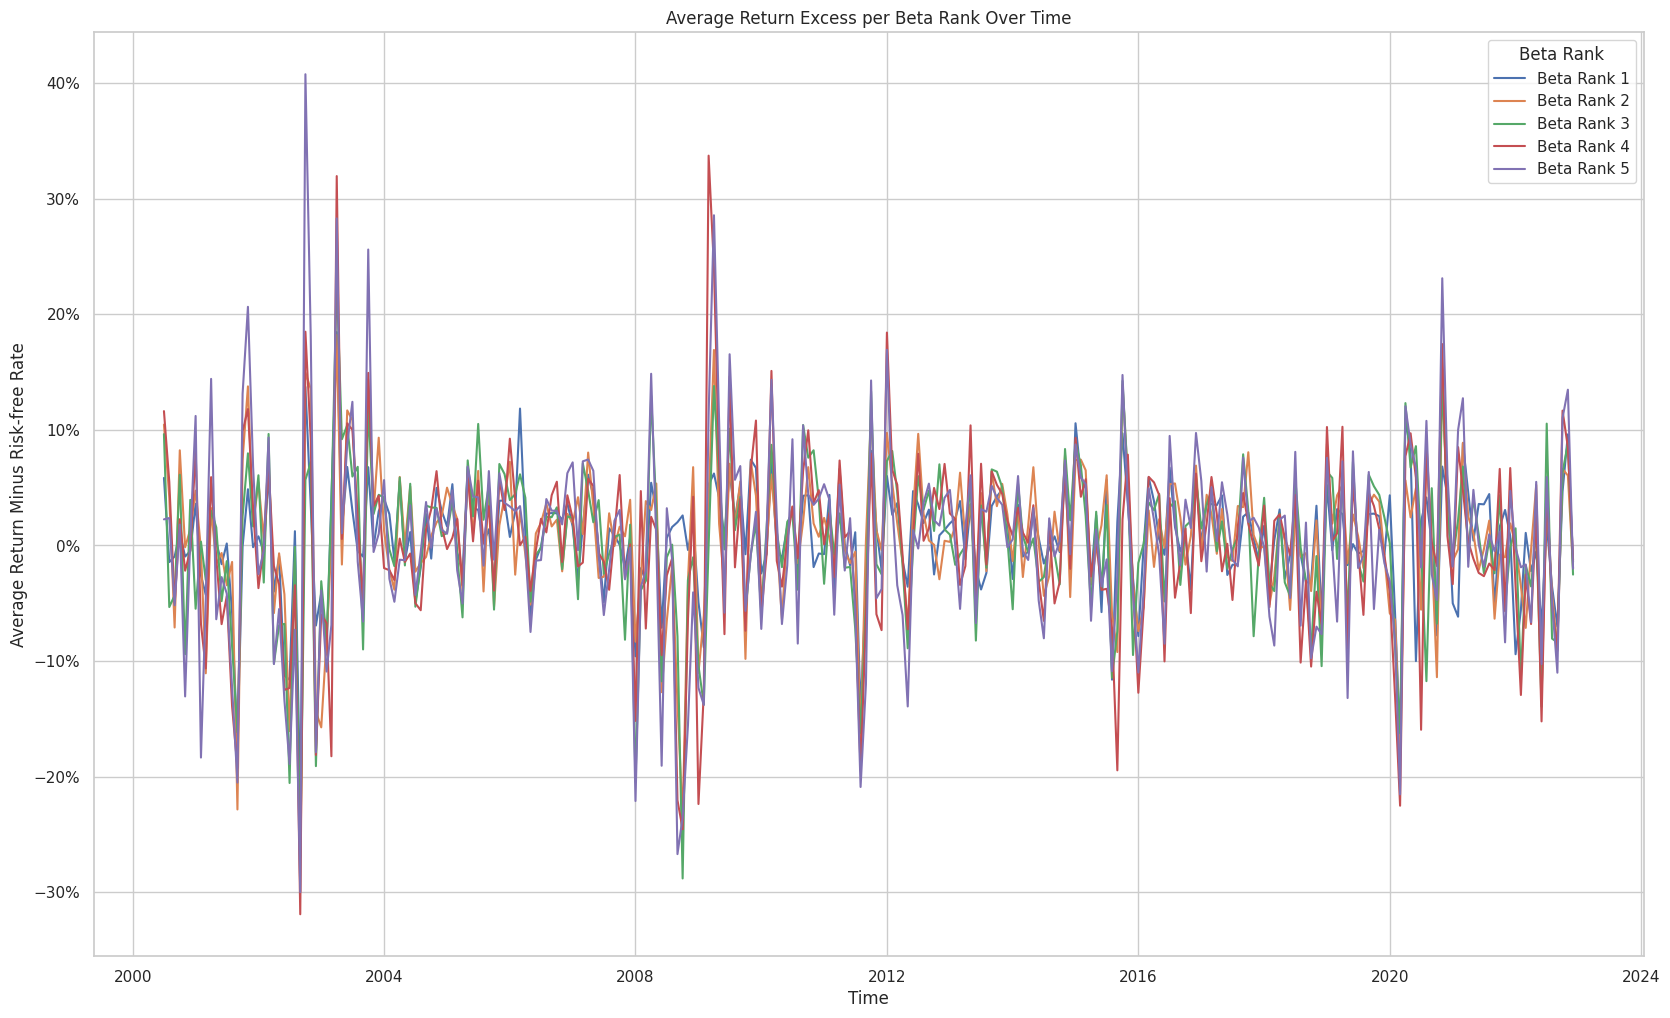

In [48]:
# Plotting 'Avg. Return' per 'Comove Rank' over time

# Convert the MMYYYY to a Proper Date Format first
data.reset_index(inplace=True)
data['MMYYYY'] = pd.to_datetime(data['MMYYYY'], format='%m%Y')
data.set_index('MMYYYY', inplace=True)

# Set the style
sns.set(style="whitegrid")

plt.figure(figsize=(20, 12))
for rank in sorted(data['Beta rank'].unique()):
    subset = data[data['Beta rank'] == rank]
    plt.plot(subset['Avg. Return Excess'], label=f'Beta Rank {rank}')

plt.xlabel('Time')
plt.ylabel('Average Return Minus Risk-free Rate')

# Format y-axis as percentage
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

plt.title('Average Return Excess per Beta Rank Over Time')
plt.legend(title="Beta Rank")

plt.savefig('Return_Ranks1to5.png')
plt.show()

Since this is a bit unclear, we will now look only at the returns of portfolios with a beta rank of 1 or 5:

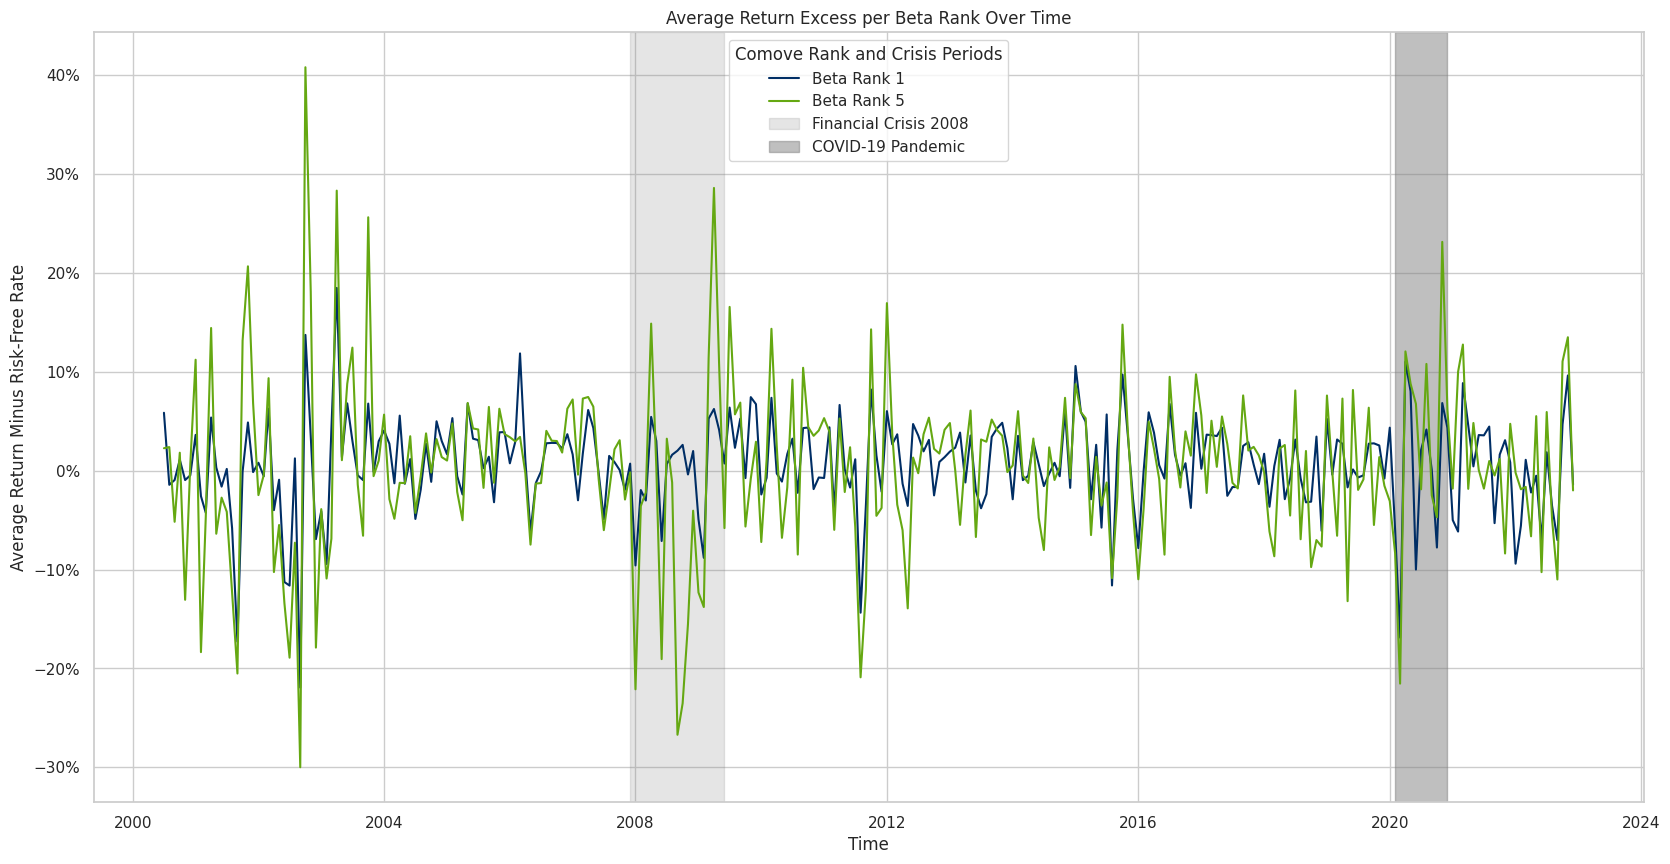

In [49]:
# Plotting 'Avg. Return' per 'Comove Rank' over time - Only Beta 1 and 5

colors = {1: '#002E65', 5: '#65A812'}  # Map comove ranks to specific colors

# Convert the MMYYYY to a Proper Date Format first
data.reset_index(inplace=True)
data['MMYYYY'] = pd.to_datetime(data['MMYYYY'], format='%m%Y')
data.set_index('MMYYYY', inplace=True)

# Set the style
sns.set(style="whitegrid")

plt.figure(figsize=(20, 10))
for rank in [1,5]:
    subset = data[data['Beta rank'] == rank]
    plt.plot(subset['Avg. Return Excess'], label=f'Beta Rank {rank}', color=colors[rank])

# Highlight crisis periods
plt.axvspan('2007-12-01', '2009-06-01', color='grey', alpha=0.2, label='Financial Crisis 2008')  # Financial crisis of 2008
plt.axvspan('2020-02-01', '2020-12-01', color='grey', alpha=0.5, label='COVID-19 Pandemic')  # COVID-19 Pandemic

plt.xlabel('Time')
plt.ylabel('Average Return Minus Risk-Free Rate')

# Format y-axis as percentage
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

plt.title('Average Return Excess per Beta Rank Over Time')
plt.legend(title = "Comove Rank and Crisis Periods")

plt.savefig('Return_Ranks1and5.png')
plt.show()

As there are large economic downturns during crisises, and large recoveries after, u can see that rank 1 clearly has a larger market sensitity. Overall, Comove rank 5 seems to have little bit higher return.

To really see the difference, we will now calculate the cummulative return over time.

<ipython-input-50-f69b152b0f8d>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['Cumulative Return'] = (1 + subset['Avg. Return Excess']).cumprod() - 1
<ipython-input-50-f69b152b0f8d>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['Cumulative Return'] = (1 + subset['Avg. Return Excess']).cumprod() - 1


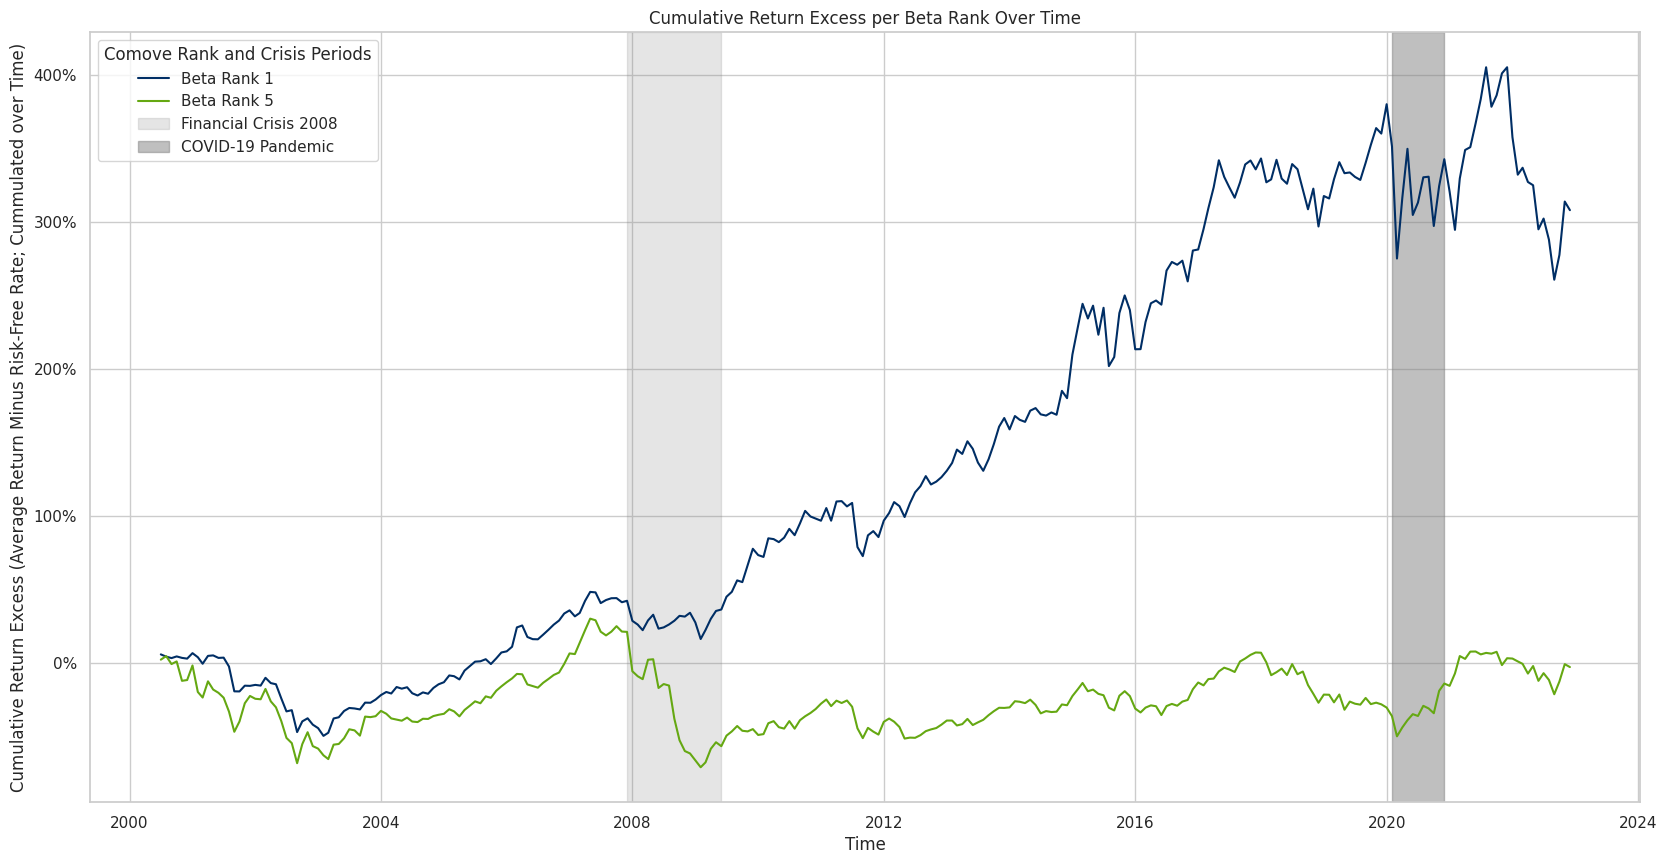

In [50]:
# Set the style
sns.set(style="whitegrid")
colors = {1: '#002E65', 5: '#65A812'}  # Map comove ranks to specific colors

plt.figure(figsize=(20, 10))
for rank in [1, 5]:
    subset = data[data['Beta rank'] == rank]
    subset['Cumulative Return'] = (1 + subset['Avg. Return Excess']).cumprod() - 1
    plt.plot(subset.index, subset['Cumulative Return'], label=f'Beta Rank {rank}', color=colors[rank])

# Highlight crisis periods
plt.axvspan('2007-12-01', '2009-06-01', color='grey', alpha=0.2, label='Financial Crisis 2008')
plt.axvspan('2020-02-01', '2020-12-01', color='grey', alpha=0.5, label='COVID-19 Pandemic')

# Set labels and title
plt.xlabel('Time')
plt.ylabel('Cumulative Return Excess (Average Return Minus Risk-Free Rate; Cummulated over Time)')

# Format y-axis as percentage
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

plt.title('Cumulative Return Excess per Beta Rank Over Time')
plt.legend(title = "Comove Rank and Crisis Periods")

# Save the figure
plt.savefig('CummulativeReturn_Ranks1and5.png')
plt.show()